# LiberTEM Architecture
From https://libertem.github.io/LiberTEM/architecture.html

![LiberTEM Architecture](source/LiberTEM/docs/source/images/architecture.png)


# UDFs

![LiberTEM UDFs](UDF.svg.png)

# Installation 

## conda env + jupyter
- create a conda environment, for example: `$ conda create -p ./libertem-workshop python=3.7`
- activate that environment: `$ source activate ./libertem-workshop`
- `$ pip install ipykernel` (or the conda equivalent)
- `$ python -m ipykernel install --user --name libertem-workshop --display-name "Python (libertem workshop)"`
- You can check if the installation was successful by running `$ jupyter kernelspec list`

After these steps, visit the jupyterhub in your browser, and you should have a "Python (libertem workshop)" kernel available when creating a new notebook. If you later want to remove the jupyter kernel entry, run `$ jupyter kernelspec uninstall libertem-workshop`

## Installing LiberTEM

`$ cd ./libertem-workshop && pip install -e git+https://github.com/libertem/libertem#egg=libertem`

This will install the current LiberTEM git version (you can also clone and `pip install -e .` as shown in the documentation)

# Using LiberTEM

In [1]:
%env OMP_NUM_THREADS=1
%env MKL_NUM_THREADS=1
%env OPENBLAS_NUM_THREADS=1
%matplotlib nbagg

env: OMP_NUM_THREADS=1
env: MKL_NUM_THREADS=1
env: OPENBLAS_NUM_THREADS=1


In [2]:
import matplotlib.pyplot as plt
import libertem.api as lt
from libertem.common.buffers import BufferWrapper
from libertem.udf.base import UDF
import numpy as np

In [3]:
ctx = lt.Context()

# Specifying the dataset

For MIB files, just point to the `.hdr` file; if you don't have one, point to (one of) the `.mib` file(s) and specify the scan size as a tuple `(y, x)`.

In [4]:
ds = ctx.load("mib", path="/home/clausen/Data/Merlin/strain_karina/MOSFET/20181119 185412/default.hdr")

In [5]:
ds.diagnostics

[{'name': 'Data type', 'value': 'u08'},
 {'name': 'Partition shape', 'value': '(2048, 256, 256)'},
 {'name': 'Number of partitions', 'value': '32'}]

# Standard analyses: virtual detector, first moment / COM

In [6]:
ring = ctx.create_ring_analysis(dataset=ds, ri=60, ro=70)

In [7]:
ring_res = ctx.run(ring)
ring_res

[<AnalysisResult: intensity>]

<IPython.core.display.Javascript object>


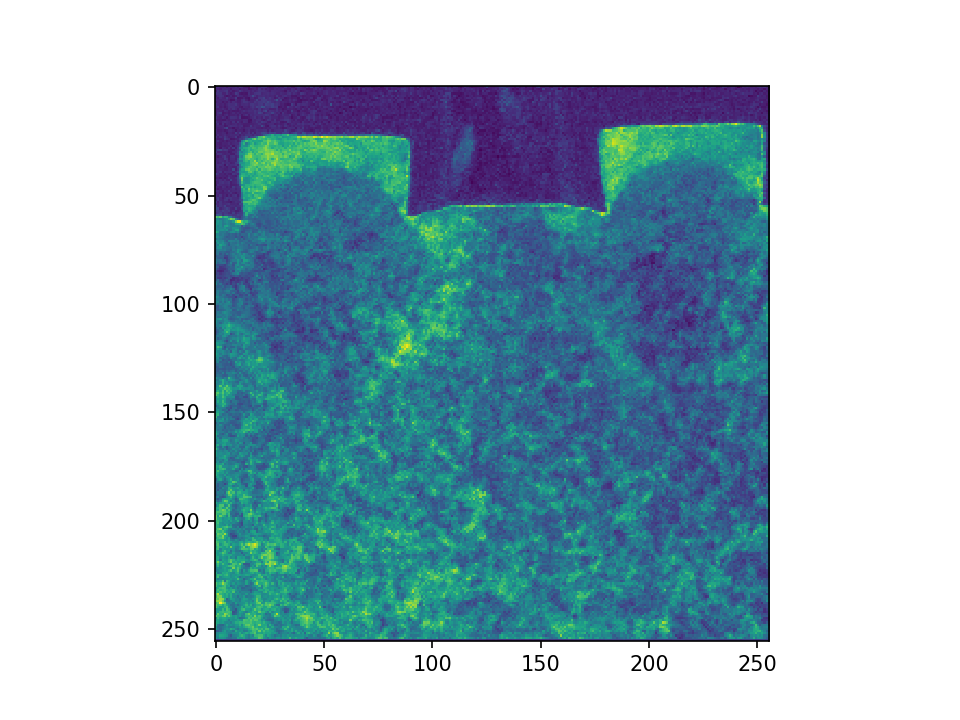

In [8]:
plt.figure()
plt.imshow(ring_res.intensity.raw_data)

# Simple UDF definition

 - simple things are simple
 - no custom merge function - array assignment by default

In [9]:
class PixelsumUDF(UDF):
    def get_result_buffers(self):
        return {
            'pixelsum': BufferWrapper(
                kind="nav", dtype="float32"
            )
        }

    def process_frame(self, frame):
        self.results.pixelsum[:] = np.sum(frame)

In [10]:
pixelsum = PixelsumUDF()
res_pixelsum = ctx.run_udf(dataset=ds, udf=pixelsum)

<IPython.core.display.Javascript object>


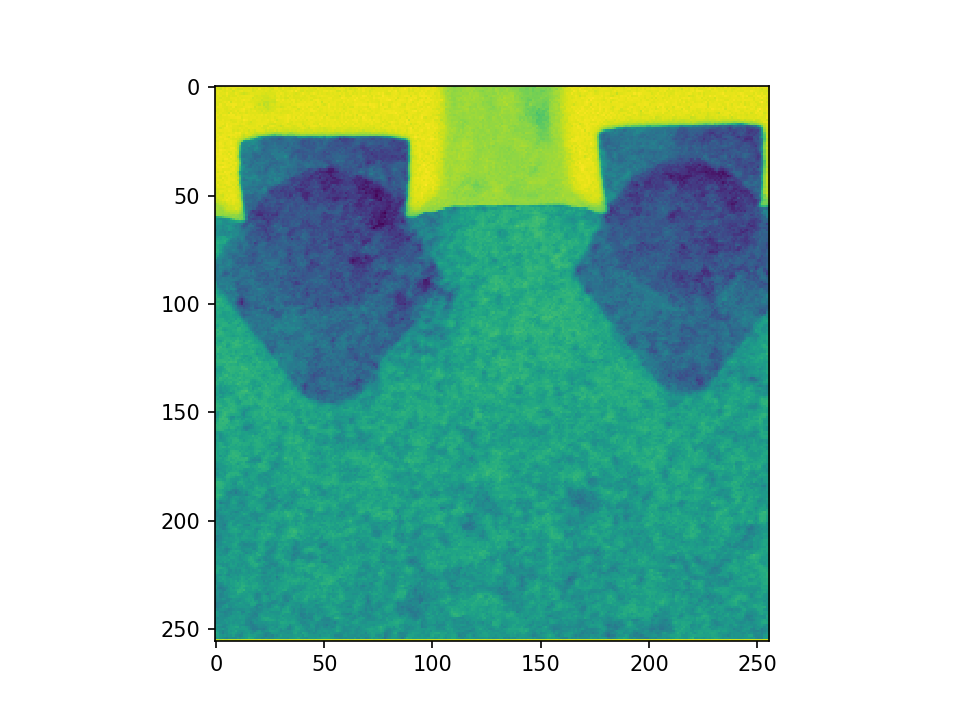

In [11]:
plt.figure()
plt.imshow(res_pixelsum['pixelsum'].data)

# `extra_shape`: more than one result per scan position

In [12]:
class StatsUDF(UDF):
    def get_result_buffers(self):
        return {
            'stats': BufferWrapper(kind='nav', extra_shape=(4,), dtype='float32'),
        }

    def process_frame(self, frame):
        # self.results.stats.shape: (4,)
        self.results.stats[:] = (np.mean(frame), np.min(frame), np.max(frame), np.std(frame))

In [13]:
res_stats = ctx.run_udf(
    dataset=ds,
    udf=StatsUDF(),
)

Result now has extra dimensions, as specified by `extra_shape` above:

In [14]:
res_stats['stats'].data.shape

(256, 256, 4)

<IPython.core.display.Javascript object>


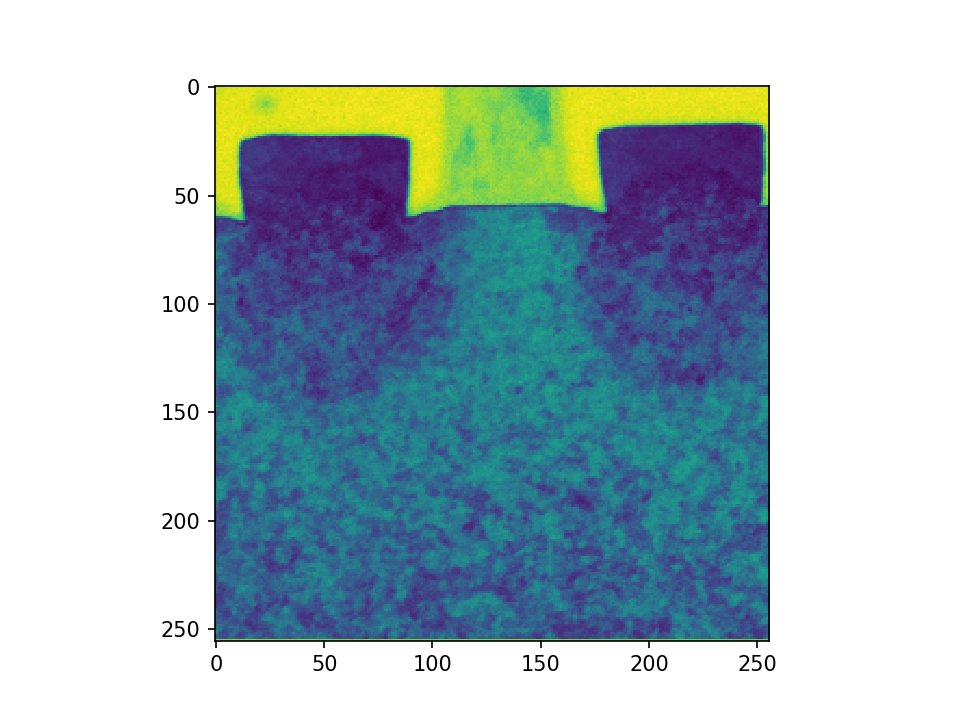

In [15]:
plt.figure()
plt.imshow(res_stats['stats'].data[..., 3])

# kind="sig" buffers, merge functions
- previously: one result for each scan position
- now: result buffer shaped like the diffraction patterns

In [16]:
class MaxFrameUDF(UDF):
    def get_result_buffers(self):
        return {
            'maxframe': BufferWrapper(kind='sig', dtype='float32')
        }

    def process_frame(self, frame):
        self.results.maxframe[:] = np.maximum(self.results.maxframe, frame)

    def merge(self, dest, src):
        dest['maxframe'][:] = np.maximum(dest['maxframe'], src['maxframe'])

In [17]:
res_max = ctx.run_udf(
    dataset=ds,
    udf=MaxFrameUDF()
)

<IPython.core.display.Javascript object>


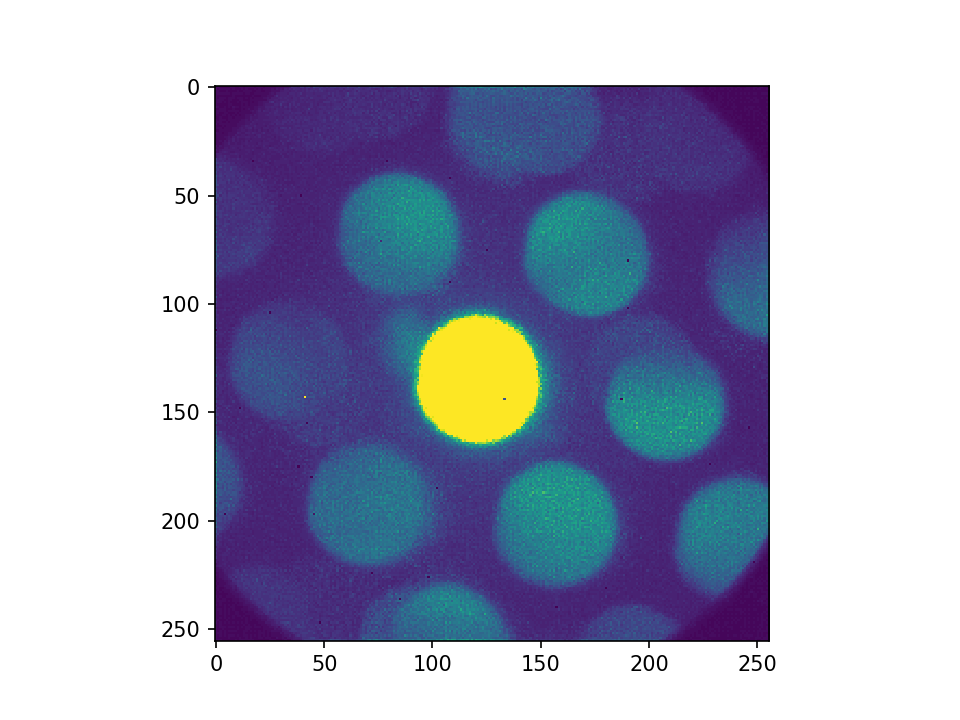

In [18]:
plt.figure()
plt.imshow(res_max['maxframe'].data)

# Region of interest

- work on a subset of diffraction patterns
- defined as mask

In [19]:
from skimage.morphology import opening, closing

<IPython.core.display.Javascript object>


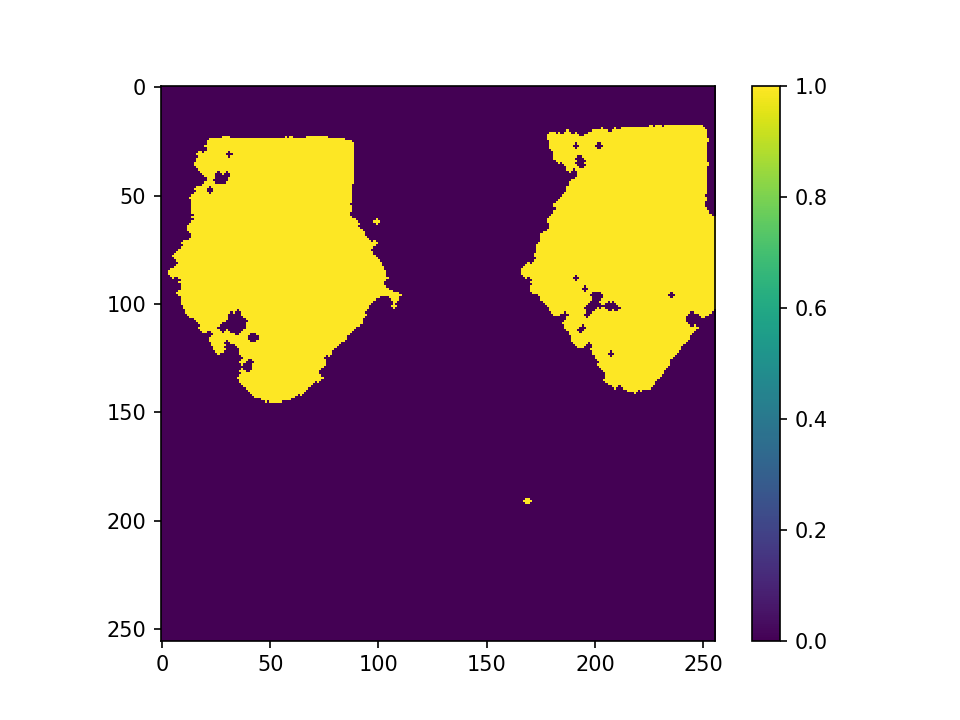

In [20]:
mask = res_pixelsum['pixelsum'].data < 1.25e5
# mask = opening(mask)
mask = closing(opening(mask))

plt.figure()
plt.imshow(mask.astype("float32"))
plt.colorbar()

In [21]:
res_roi = ctx.run_udf(
    dataset=ds,
    udf=PixelsumUDF(),
    roi=mask,
)

<IPython.core.display.Javascript object>


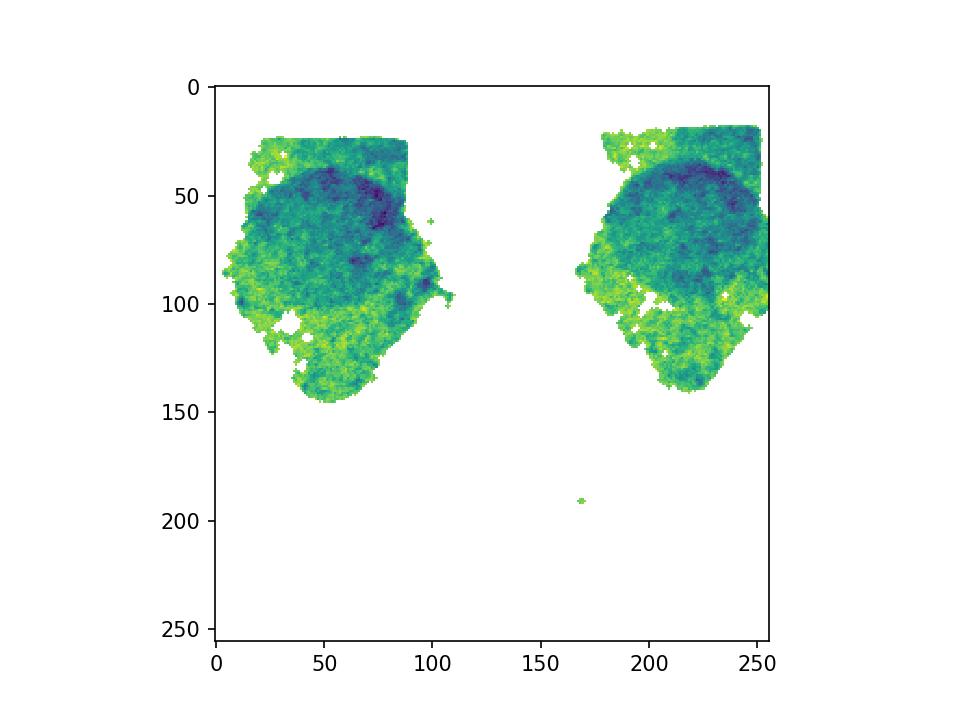

In [22]:
plt.figure()
plt.imshow(res_roi['pixelsum'].data)

In [23]:
res_roi['pixelsum'].data.shape

(256, 256)

In [24]:
res_roi['pixelsum'].raw_data.shape

(16232,)

# Extra: mask-based analyses
With an all-ones mask, equivalent to pixelsum example above:

In [25]:
mask_analysis = ctx.create_mask_analysis(dataset=ds, factories=[lambda: np.ones((256, 256))])

In [26]:
res_mask = ctx.run(mask_analysis)

<IPython.core.display.Javascript object>


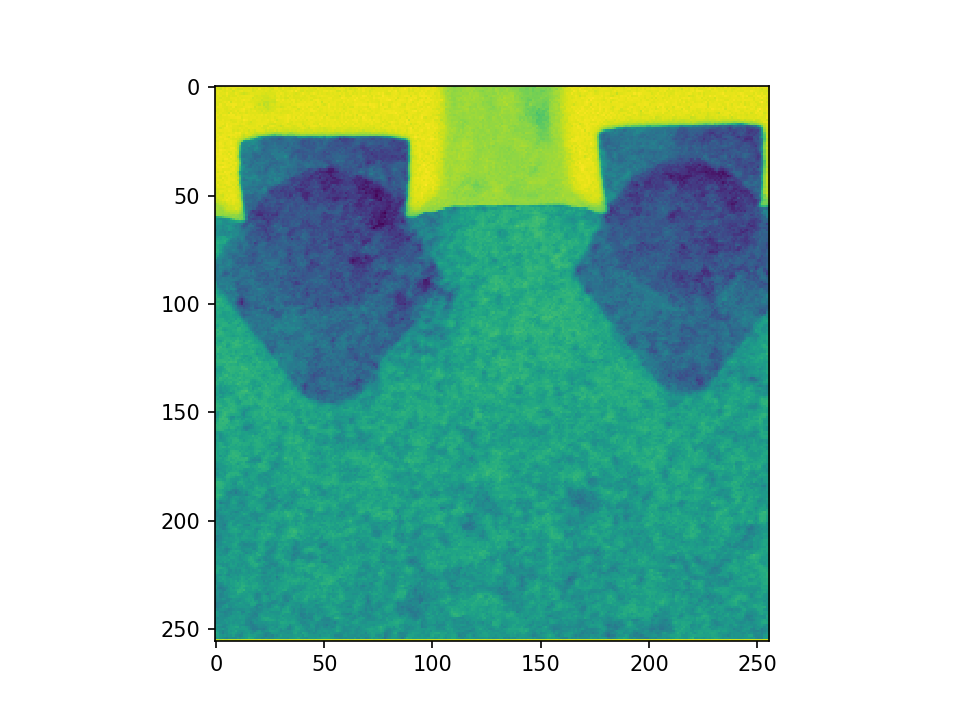

In [27]:
plt.figure()
plt.imshow(res_mask[0].raw_data)